# Multi-Object Tracking Using Graph Matching

### 1. Import modules

In [1]:
import numpy as np
import cv2
import glob
from PIL import Image
from scipy import ndimage
import two_cc 
import matplotlib.pyplot as plt
import math
from random import random, randint
import munkres
import os

Munkres is a library for computing Hungarian Algorithm - solves matching problem for matrices.

### 2. Get frames from a movie

For the first time getting frams from movie is necessary.

In [2]:
# # Getting frames from movie
# vidcap = cv2.VideoCapture('Capt2.mp4')
# success,image = vidcap.read()
# count = 0
# frames=[]
# while success:
#     cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file  
#     success,image = vidcap.read()
#     count += 1

### 3. Upload frames

First of all, let's upload frames of chosen movie.

In [3]:
frames=[]
for i in range(297):
    image=Image.open("./frames/frame"+str(i)+".jpg")
    w, h = image.size
    image=image.crop((0, 250, 500, h-50))
    frames.append(image)

### 4. Image segmentation

We can use any of image segmentation method provided by our team. We have to import desired method in the "Import modules" part. Then we use it in the "Pipeline" section.

### 5. Blocks construction

construct_blocks(): We will work on array with smaller size than size of our frames. To implement this we divide frames into 8x8 blocks. We have to be careful: on the border we can have less than 8 pixels in width/height. We assume that block is significant (contains part of an object) if it contains more than 10 foreground pixels. We assign 1 to such blocks.

In [ ]:
def construct_blocks(support_map): 
    sms=support_map.shape
    width=math.ceil(sms[0]/8)
    height=math.ceil(sms[1]/8)
    blocks=np.zeros( (width, height) )
    for i in range(width):
        for j in range(height):
            fore_pixels=0
            for k in range(min(8, sms[0]-8*i)): 
                for l in range(min(8, sms[1]-8*j)):
                    if support_map[8*i+k][8*j+l]==1:
                        fore_pixels+=1
            if fore_pixels>10:
                blocks[i][j]=1
    return blocks

connected_blocks(), dfs(): We will use algorithm based on DFS to find "connected" boxes. We will assign different integer number to all of them. This approach also gives as possibility to count elements of each components. This will be useful in the future.

In [4]:
def dfs(array,box,i,j,index,nums,indices):
    nums+=1
    if i-1 > 0 and array[i-1][j]==1.0 and box[i-1][j]==0.0:
            box[i-1][j]=index
            indices[index].append((i-1,j))
            nums=dfs(array,box,i-1,j,index,nums,indices)
    if j-1 > 0 and array[i][j-1]==1.0 and box[i][j-1]==0.0:
            box[i][j-1]=index
            indices[index].append((i,j-1))
            nums=dfs(array,box,i,j-1,index,nums,indices)
    if i+1 < array.shape[0] and array[i+1][j]==1.0 and box[i+1][j]==0.0:
            box[i+1][j]=index
            indices[index].append((i+1,j))
            nums=dfs(array,box,i+1,j,index,nums,indices)
    if j+1 < array.shape[1] and array[i][j+1]==1.0 and box[i][j+1]==0.0:
            box[i][j+1]=index
            indices[index].append((i,j+1))
            nums=dfs(array,box,i,j+1,index,nums,indices)
    return nums
            
def connected_blocks(array):
    counts=dict()
    indices=dict()
    nums=0
    index=1
    indices[index]=[]
    box=np.zeros(array.shape)
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i][j]==1.0 and box[i][j]==0.0:
                box[i][j]=index
                indices[index].append((i,j))
                nums=dfs(array,box,i,j,index,nums,indices)
                counts[index]=nums
                index+=1
                indices[index]=[]
                nums=0
    indices.pop(index)
    return counts, indices

### 6. Define needed functions

Function defined below will be useful in the future. The best approach is to skip them during analysing the process and come back to their definitions and explanations when they are in use.

Our matching gives us matched pairs of blocks. But given values are indices of these blocks in the list of blocks, not their proper indices = keys (for boxes). So we will update our matching a little: we change those indices into keys. This is important because we are using keys to assign colors to objects which means assigning objects. For use number of color = index of object.

In [5]:
def update_matching(FD1, matching):
    for k in range(len(matching)): #we consider all first element in pairs in matching
        key_prev = FD1.objects[k].index #key/index of object in FD[i-1], that color  
        key_curr = matching[k][1] + 1
        matching[k] = (key_prev, key_curr)
    return matching

Now we are looking for borders of our blocks. We will use them to show objects on the frame.

Different objects have borders in distinct colors. We can get colors in more blurry way because when the group of bees splits we see big difference and I think we should not. But then our segmentation can be less readable. So for now it stays like it is. 

In [6]:
def find_borders(block_array): #used in borders_on_the_frame
    borders = np.zeros((block_array.shape[0],block_array.shape[1]),dtype='int16')
    count_neighbours=0
    neighbours_color=0
    for i in range(block_array.shape[0]):
        for j in range(block_array.shape[1]):
            if i-1 > 0 and block_array[i-1][j] > 0:
                count_neighbours+=1
                neighbours_color=block_array[i-1][j]
            if j-1 > 0 and block_array[i][j-1] > 0:
                count_neighbours+=1
                neighbours_color=block_array[i][j-1]
            if i+1 < block_array.shape[0] and block_array[i+1][j] > 0:
                count_neighbours+=1
                neighbours_color=block_array[i+1][j]
            if j+1 < block_array.shape[1] and block_array[i][j+1] > 0:
                count_neighbours+=1
                neighbours_color=block_array[i][j+1]
            if 0 < count_neighbours < 4:
                borders[i][j]=neighbours_color
            count_neighbours=0
            neighbours_color=0
    return borders

def colors(width, height): #used in set_colors()
    random_color = lambda: (int(random()*255), int(random()*255), int(random()*255))
    colors = [random_color() for i in range(width*height)]
    return colors

def set_colors(block_map, colors): #used in borders_on_the_frame
    width = block_map.shape[0]
    height = block_map.shape[1]
    colored_map = np.zeros((width,height,3), dtype='int16')
    for j in range(height):
        for i in range(width):
            colored_map[i][j] = colors[int(block_map[i][j])]
    return colored_map

In [7]:
def show_final_frame(FD, i, colors):
    f1=plt.title(f"{i+1}. frame - {len(FD[i].objects)} objects")
    f1=plt.imshow(FD[i].borders_on_frame(colors))
    plt.show()
    
def show_match_frame(FD, i, colors):
     return FD[i].borders_on_frame(colors) 

### 7. Extract information about frames

We define special class for our objects. Each object has three attributes: 
- index - It is color assigned to object which is key in boxes distionary for the frame. It is unique as it is index of detected object.
- size - It gives us information how many blocks our object contains.
- position - We represent objects mainly by their position: center of mass of the object.

In [8]:
class Object:
    def __init__(self, index, size, position=None):
                
        self.index = index
        self.size = size
        self.position = position

We also define special class for data of our frames. Each class element has four attributes: 
- objects - list of objects detected on the frame 
- boxes - dictionary with colors as keys and pixels assigned to the color as values
- frame - current frame

This class is quite big as we perform a lot of operations on frames. Let's go through its functions:

- list_of_indices() - return all indices (colors, keys) assigned to objects
- smallest_missing_key() - return smallest key/color which is not in use
- set_positions() - finds coordinates of mass of center of objects
- array_boxes(), reconstruct_array(), borders_on_the_frame() - functions needed to present effects of object's tracking
- add_objects(), update_add() - to create empty objects. Our goal is to have two sets of vertices of bipartite graph with the same cardinality at each step of algorithm.
- change_frame() - to apply changes resulting from the matching. It changes color assigned to the object and the blocks. Because we change both of those things we do not have to worry about changing size.
- update_remove() - to delete empty objects (There is additional condition in the function which has nothing in common with being empty.There are cases when adjacent frames have diffent keys/colors. Then previous function during making changes could remain some object with key which is not in use in the current frame but appeared in the previous one.).


In [9]:
class Frame_Data:       
    def __init__(self, blocks_data, list_boxes, frame):
        keys =  list(blocks_data.keys())
        self.objects = [Object(keys[i], blocks_data[i+1]) for i in range(len(blocks_data))].copy()
        self.boxes = list_boxes.copy()
        self.frame = frame.copy()
        
        
    def list_of_indices(self):
        indices=[]
        for obj in self.objects:
            indices.append(obj.index)
        return indices
    
    def smallest_missing_key(self):
        key=1
        keys = self.boxes.keys()
        while (True):
            if key in keys:
                key+=1
            else:
                return key
            
            
    def set_positions(self): 
        for key, points in self.boxes.items():
            array = np.zeros(self.frame.size) 
            for point in points:
                array[point]=1
            self.objects[self.list_of_indices().index(key)].position = ndimage.measurements.center_of_mass(array)              
    
    
    def array_boxes(self):
        array = np.zeros(self.frame.size)
        for key in self.boxes.keys():
            for pixels in self.boxes[key]:
                array[pixels]=key
        return array
            
    def reconstruct_array(self):
        blocks=self.array_boxes()
        shape=self.frame.size
        frame_array = np.zeros((shape[1],shape[0]), dtype='int16')
        for index,block in np.ndenumerate(blocks):
            if block > 0: 
                for i in range(8*index[0], min(shape[1], 8*index[0]+8)):
                    for j in range(8*index[1], min(shape[0], 8*index[1]+8)):
                        frame_array[i][j]=block
        return frame_array
    
    def borders_on_frame(self, colors):
        borders_map = find_borders(self.reconstruct_array())    
        shape=self.frame.size
        frame_array = np.array(self.frame, dtype='int16')
        colored_borders=set_colors(borders_map, colors)
        for i in range(shape[1]):
            for j in range(shape[0]):
                if borders_map[i][j]>0:
                    frame_array[i][j]=colored_borders[i][j]
        return frame_array
            
            
    def add_objects(self, object_list): #adding new objects which are in the object_list
        for new in object_list:
            self.objects.append(new)  
            
    def update_add(self, card): 
        for i in range(len(self.boxes), card):
            key = self.smallest_missing_key()
            self.add_objects([Object(key, 0)])
            self.boxes[key]=[]
 
    def change_frame(self, boxes, matching): 
        for ind, pair in enumerate(matching): 
            self.boxes[pair[0]] = boxes[pair[1]]
            self.objects[pair[1]-1].index = pair[0]    
            
    def update_remove(self): #remove too much boxes
        self.boxes = {key:val for key, val in self.boxes.items() if ( val != [] and key in self.list_of_indices() )}
        self.objects = [ obj for obj in self.objects if obj.size!=0]  

### 8. Get the matching between adjacent frames

There we have the last class responsible for matching. Each matching has three attributes:
- X_set - objects from previous frame
- Y_set - objects from current frame
- set_card - cardinality of bigger of sets. In our approach both sets of objects are the same size.

We have only two functions in this class:
- create_cost_matrix() - It creates a matrix which has objects of previous frame as rows and objects of current frame as columns. Values are distances between positions of objects on adjacent frames. Distance to empty object is always 0.
- find_matching() - This function creates a cost matrix using function mentioned above. Then using Hungarian Algorithm it computes the matching.

In [10]:
class Matching:
    def __init__(self, FD1, FD2):
        self.X_set = FD1.objects.copy()
        self.Y_set = FD2.objects.copy()
        self.set_card = max(len(FD1.objects), len(FD2.objects))

    def create_cost_matrix(self):
        card = self.set_card
        cost_matrix = np.zeros((card, card))
        for i in range(card):
            for j in range(card):
                value=0.00
                if (self.X_set[i].size != 0) and (self.Y_set[j].size != 0):
                    for k in [0,1]:
                        value += (self.X_set[i].position[k] - self.Y_set[j].position[k])**2
                cost_matrix[i][j] = round(math.sqrt(value),3)
        return cost_matrix
        
    def find_matching(self):
        C = self.create_cost_matrix()
        m = munkres.Munkres()
        indexes = m.compute(C)
        return indexes

### 9. Pipeline

The main algorithm at each step creates segmented image, blocks and boxes. We do not do this at once to do not make user wait so long for first effects. When we consider current and previous frames, we add empty objects to make their cardinalities the same (and also the smallest possible, we do not add as many objects as we want). Then we find a matching between frames and update it with keys/colors of objects. Then we apply the changes based on the matching. Finally, we remove empty objects and set positions of the objects on the current frame (as it will be in use in the next step as the previous frame).

In [11]:
def pipeline_final(start_frame, end_frame):
    width, height = math.ceil(frames[0].size[0]/8), math.ceil(frames[0].size[1]/8)
    diameter = math.sqrt(width**2 + height**2)
    color = colors(width, height)
    segment, blocks, count_boxes, list_boxes, FD, matchings = [], [] ,[], [], [], []
    for i in range(start_frame):
        segment.append(None)
        blocks.append(None)
        count_boxes.append(None)
        list_boxes.append(None)
        FD.append(None)
        matchings.append(None)
    for i in range(start_frame, end_frame):
        segment.append(two_cc.two_connected_components(frames[i],channel="red",thresh=86))
        blocks.append(construct_blocks(segment[i]))
        count_boxes_, list_boxes_ = connected_blocks(blocks[i])
        count_boxes.append(count_boxes_)
        list_boxes.append(list_boxes_)
        FD.append(Frame_Data(count_boxes[i],list_boxes[i], frames[i]))
        FD[i].set_positions()
        if i>start_frame:
            card = max(len(FD[i-1].boxes), len(FD[i].boxes))
            FD[i-1].update_add( card)
            FD[i].update_add( card)    
            M = Matching(FD[i-1], FD[i]) 
            matching = M.find_matching()
            matching = update_matching(FD[i-1], matching)
            boxes=FD[i].boxes.copy()
            FD[i].change_frame(boxes, matching)
            FD[i].update_remove()
            FD[i].set_positions()
#         show_final_frame(FD, i, color)
        matchings.append(show_match_frame(FD, i, color))
    return matchings

### 10. Get the objects on the frames (after matching)

In [12]:
start_frame = 0
end_frame = 100

In [13]:
matchings = pipeline_final(start_frame, end_frame)

### 11. Save matched frames

In [14]:
for i in range(start_frame, end_frame):
    cv2.imwrite(".\matched\match%d.jpg" % i, np.float32(matchings[i]) )   

### 12. Create a tracking movie

The best way to show effects of tracking is to join frames after matching into one movie.

In [15]:
pathOut = 'tracking_video.mkv'
tracking_movie = cv2.VideoWriter(pathOut, apiPreference=0, fourcc = cv2.VideoWriter_fourcc(*'DIVX'), fps=15, frameSize=frames[0].size)
for i in range(start_frame, end_frame):
    tracking_movie.write( np.uint8(matchings[i]) )
tracking_movie.release()

### 13. Some examples

In [16]:
def show_adjacent_matched_frames(matchings, i, colors):
    f=plt.figure(figsize=(11,5))
    f1=f.add_subplot(1,2,1)
    f1=plt.title(f"{i}. frame")
    f1=plt.imshow(matchings[i])
    f2=f.add_subplot(1,2,2)
    f2=plt.title(f"{i+1}. frame")
    f2=plt.imshow(matchings[i+1])
    plt.show()

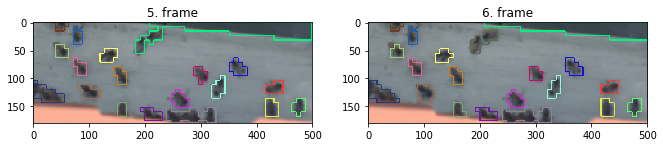

In [17]:
show_adjacent_matched_frames(matchings, 5, colors)

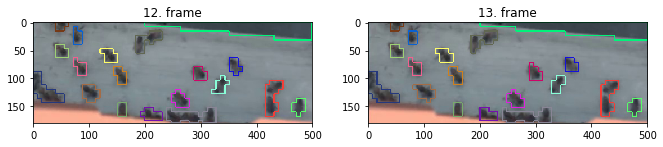

In [19]:
show_adjacent_matched_frames(matchings, 12, colors)

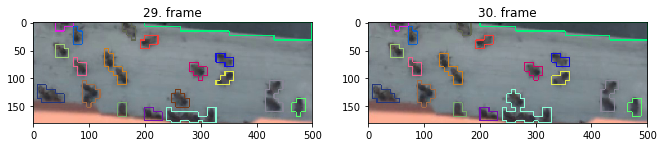

In [22]:
show_adjacent_matched_frames(matchings, 29, colors)

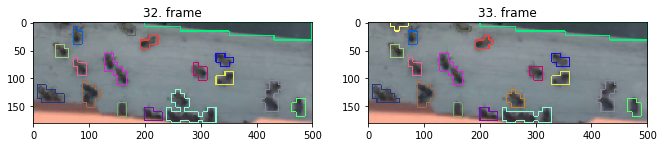

In [23]:
show_adjacent_matched_frames(matchings, 32, colors)

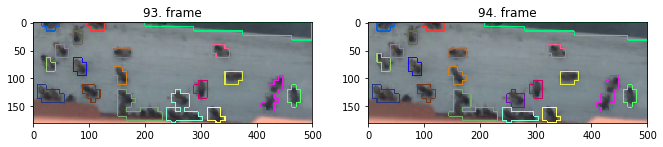

In [31]:
show_adjacent_matched_frames(matchings, 93, colors)

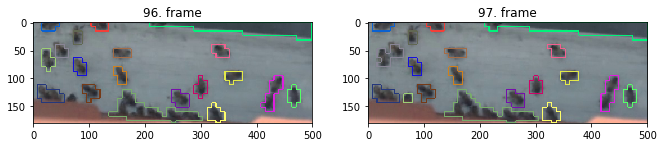

In [32]:
show_adjacent_matched_frames(matchings, 96, colors)